## Gene essentiality by CRISPR KO

In this notebook, we look at a few example genes to see how essentiality in cell lines suggests possible function.

In [2]:
# import needed packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42
import utils
import rpy2
%load_ext rpy2.ipython

The first step is to read the data from DepMAP regarding gene essentiality scores (CERES scores) and mutation data. CERES scores are more negative if a gene is essential, reflecting loss in guide RNAs targeting that gene.

In [9]:
mut_flag = pd.read_csv('data/depmap/mutation_flags.txt', sep='\t', index_col=0).rename(columns=lambda x:x+'_flag')
ceres_df = pd.read_csv('data/depmap/gene_essentiality_ceres.txt', sep='\t')
ceres_df = pd.merge(ceres_df, mut_flag, left_on='DepMap_ID', right_index=True, how='left').dropna(subset=['FBXW7'])

### Examine GATA3 essentiality

For the first example, we look at the essentiality of GATA3 in mutated vs wildtype breast cancer cell lines. The first step is to process the data to look at GATA3 compared to an oncogene (BRAF), a dominant-negative tumor suppressor (FBXW7), a two-hit tumor suppressor (RB1) and a passenger gene (TTN).

In [17]:
df_list = []
gene_list = ['GATA3', 'BRAF', 'FBXW7', 'RB1', 'TTN']
for gene in gene_list:
    if gene == 'GATA3':
        is_mut = ceres_df[gene+'_flag'].isin(['driver missense', 'LOF', 'frameshift'])
        is_breast_cancer = (ceres_df['Primary Disease']=='Breast Cancer')
        tmp = pd.DataFrame({'gene': gene, 
                            'type': 'mutant',
                            'CERES score': ceres_df.loc[is_mut & is_breast_cancer, gene].values}) 
    else:
        tmp = pd.DataFrame({'gene': gene, 
                            'type': 'mutant',
                            'CERES score': ceres_df.loc[ceres_df[gene+'_flag'].isin(['driver missense', 'LOF', 'frameshift']), gene].values})

    df_list.append(tmp)
    if gene == 'GATA3':
        is_other = ceres_df[gene+'_flag']=='other'
        is_breast_cancer = (ceres_df['Primary Disease']=='Breast Cancer')
        tmp2 = pd.DataFrame({'gene': gene, 'type': 'WT',
                         'CERES score': ceres_df.loc[is_other & is_breast_cancer, gene].values})
    else:
        tmp2 = pd.DataFrame({'gene': gene, 'type': 'WT',
                         'CERES score': ceres_df.loc[ceres_df[gene+'_flag']=='other', gene].values})
    df_list.append(tmp2)
plot_df = pd.concat(df_list)

Next, we plot the gene essentiality scores stratified by mutation status. We see that GATA3 mutant samples seem to still be essential when mutated (a CERES score of -1 means essential).

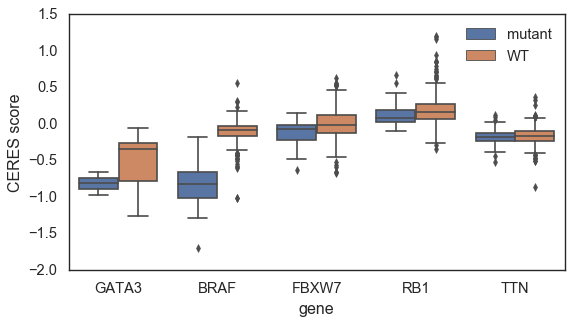

In [18]:
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.2):
    sns.boxplot(x='gene', y='CERES score', hue='type', data=plot_df, )
    plt.gcf().set_size_inches(8,4)
    plt.legend(frameon=False)
    plt.savefig('figures/gata3_depmap_comparison.pdf')

### Examine the essentiality of PPM1D

We next examined the case of PPM1D, which contains truncating mutations predicted by deepDegron to lead to degron loss. PPM1D is thought to be a negative regulator of TP53, which would suggest a role for PPM1D as an oncogene despite containing truncating mutations.

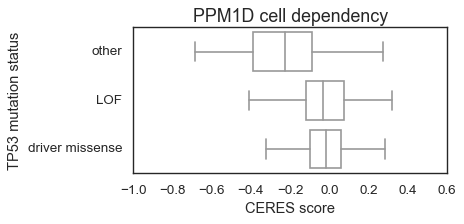

In [32]:
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.1):
    sns.boxplot('PPM1D', 'TP53_flag', data=ceres_df, color='white', fliersize=0)
    plt.gcf().set_size_inches(6, 3)
    plt.xlabel('CERES score')
    plt.ylabel('TP53 mutation status')
    plt.title('PPM1D cell dependency', size=16)
    plt.tight_layout()
    plt.savefig('figures/ppm1d_essentiality.pdf')

In [25]:
stats.ttest_ind(ceres_df.loc[ceres_df['TP53_flag'].isin(['driver missense', 'LOF', 'frameshift']), 'PPM1D'],
ceres_df.loc[ceres_df['TP53_flag']=='other', 'PPM1D'])

Ttest_indResult(statistic=13.745955898748944, pvalue=3.455177794405783e-37)